# 11.0 Model Evaluation and Training
Here I perform the following tasks:

- 1) Evaluate the performance of different algorithms with KFold cross-validation, to determine which is best at modeling un-seen data.
- 2) After selecting an algorithm I perform a feature importance analysis to remove features that are not adding any value.
- 3) Peform a grid search to find the optimal parameters for the final algorithm.
- 4) Train the final model.
- 5) Prepare a home credit competition submission file.

In [29]:
#ml algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
import xgboost as xgb
from lightgbm import LGBMClassifier

# CV, Gridsearch, train_test_split, model selection packages
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

# Classifier Metrics 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score

# Pre-processing packages
from sklearn.preprocessing import StandardScaler


## 11.1 Import Normalized Dataset
Here we import the training that has already been normalized.

In [2]:
dataset =  pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\results\train_norm.csv")

In [34]:
dataset

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,EXT_SOURCE_2,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,EXT_SOURCE_1,EXT_SOURCE_3,...,NAME_FAMILY_STATUS_MAP_2,NAME_FAMILY_STATUS_MAP_3,NAME_FAMILY_STATUS_MAP_4,NAME_FAMILY_STATUS_MAP_5,NAME_HOUSING_TYPE_MAP_0,NAME_HOUSING_TYPE_MAP_1,NAME_HOUSING_TYPE_MAP_2,NAME_HOUSING_TYPE_MAP_3,NAME_HOUSING_TYPE_MAP_4,NAME_HOUSING_TYPE_MAP_5
0,-0.862538,-0.743626,-1.014157,-0.019215,0.356886,-1.175831,2.438415,0.570637,-1.971493,-1.176664,...,0,1,0,0,0,0,0,0,0,1
1,0.160922,-0.519331,0.697882,-0.650005,-0.359306,1.065978,-0.310240,-1.573089,-0.455155,0.031456,...,0,0,0,0,0,1,0,0,0,0
2,1.157228,2.179913,1.599043,2.029631,-0.432682,1.136863,-0.310240,0.775340,3.522805,0.185182,...,0,0,0,0,0,1,0,0,0,0
3,1.075578,0.531229,2.062030,-0.019215,0.655172,0.945854,-0.310240,0.418680,-1.239534,2.084732,...,0,0,0,0,0,1,0,0,0,0
4,-1.706757,0.748108,1.355544,-0.729995,-1.508412,-0.438918,-0.310240,0.088393,1.920078,1.086620,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48458,0.763339,-0.066817,0.622586,0.024345,1.058205,-0.669108,-0.310240,0.708780,-3.365945,-0.646174,...,0,0,0,0,0,1,0,0,0,0
48459,-0.036608,1.501557,1.308675,-0.991903,-1.506758,0.557413,-0.310240,-0.758046,1.198575,-0.265343,...,0,0,0,0,0,1,0,0,0,0
48460,0.947137,-0.679686,-0.326593,-0.893379,1.139285,1.187884,-0.310240,-2.577764,-0.056223,0.260846,...,0,0,0,0,0,1,0,0,0,0
48461,0.947137,0.150062,-0.048400,-0.428991,1.015113,0.712465,-0.310240,0.730130,-0.056223,-0.422334,...,0,0,0,0,0,1,0,0,0,0


## 11.2 Define Evaluate Models Performance

Here I evaluate the performance of different algorithms with KFold cross-validation, to determine which is best at modeling the data. Cross validation is a re-sampling technique that gives an indication how well an algorithm will perform on unseen data.

The following are the algorithms I evaluated:

1) Naive Predictor:
The naive predictor is a benchmark model that will always predict that a loan will always get repaid. This model shows what a model without any intelligence would look like.

2) Logistic Regression Classifer:
Used for binary classification problems with two class values (binary values). It is used to explain the relationship between one dependent binary variable and one or more independent variables.

3) Gradient Boosting Classifer:
A machine learning ensemble method that produces a strong model by combining weak models. It’s used on both classifications and regression problems. I will test Light Gradient Boosting

4) Two layer Neural Network implented in keras:
A neural network is a type of algorithm which models itself after the human brain. A neural network algorithm automates the process of learning patterns from data to then make predictions new data

In [4]:
# define roc_callback
def auc_roc(y_true, y_pred):
    value, update_op = tf.metrics.auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [13]:
def evaluate_models(models,X_,y_,fold_split=10):
    """ Evaluates the performance of given models."""
    results = []
    names = []
    scoring = 'roc_auc'
    for count, (name, model) in enumerate(models):
        start = time.time()
        kfold = StratifiedKFold(n_splits=fold_split)
        cv_results = cross_val_score(model, X_, y_, cv=kfold, scoring=scoring)
        end = time.time()
        results.append(cv_results)
        names.append(name)
        time_elapsed = time.strftime("%H:%M:%S", time.gmtime(time.time() - start))
        msg = " {}) Model: {} Mean: {:.4f} Std: {:.4f} Elapsed Time: {}"
        print(msg.format(count+1 ,name, cv_results.mean(), cv_results.std(),time_elapsed))
        
    #return dataframe of results
    names_rows = []
    results_rows = []
    for n,arr in zip(names,results):
        for a in arr:
            names_rows.append(n)
            results_rows.append(a)
    return pd.DataFrame({'Model':names_rows,'Score':results_rows})


In [28]:
def baseline_report_cv_(model, X_train_val, y_train_val, n_splits, name):
    """
    Accepts a model object, X (independent variables), y (target), n_splits and name of the model
    and returns a model with various scoring metrics of each classifier model on a cross-validation split
    ----
    Input: model object, X, y, n_splits (integer), name (str)
    Output: Various metric scores of a model.
    """
    # Splitting the data into 80% training/validation data and 20% testing data
#     # Splitting the training data into 60% training data and 20% validation data.
#     X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=69)
     
    # Creating a shuffled kfold of 5
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=1000) 
    
    accuracy     = np.mean(cross_val_score(model, X_train_val, y_train_val,cv=cv, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train_val, y_train_val,cv=cv, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train_val, y_train_val,cv=cv, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train_val, y_train_val,cv=cv, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train_val, y_train_val,cv=cv, scoring='roc_auc'))
    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'timetaken'    : [0]       })   # timetaken for comparison later
    return df_model

In [8]:
dataset.columns = list(map(lambda x: str(x).replace(" ", "_").replace("-", "_").replace("_/_", "_").upper(), dataset.columns))
import re
dataset = dataset.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [15]:
data_train = dataset.dropna()

In [16]:
train = data_train[data_train.TARGET.isnull() == False]
test = data_train[data_train.TARGET.isnull()]

X_train = train.drop(["TARGET", "SK_ID_CURR"], axis = 1)
X_test = test.drop(["TARGET", "SK_ID_CURR"], axis = 1)
y_train = train.TARGET

# split into train/test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=54,stratify=y_train)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.1, random_state=54,stratify=y_val)
print("X training size: {} and y training size {}:".format(X_train.shape,y_train.shape))
print("X validation size: {} and y validation size {}:".format(X_val.shape,y_val.shape))
print("X testing size: {} and y testing size {}:".format(X_test.shape,y_test.shape))

X training size: (10452, 320) and y training size (10452,):
X validation size: (1045, 320) and y validation size (1045,):
X testing size: (117, 320) and y testing size (117,):


In [33]:
gnb = GaussianNB()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
lgbm = LGBMClassifier()

df_models = pd.concat([baseline_report_cv_(gnb, X_train, y_train, 5, 'GaussianNB'),
                       baseline_report_cv_(knn, X_train, y_train, 5, 'KNN'),
                       baseline_report_cv_(decisiontree, X_train, y_train, 5, 'DecisionTree'),
                       baseline_report_cv_(randomforest, X_train, y_train, 5, 'RandomForest'),
                       baseline_report_cv_(lgbm, X_train, y_train, 5, 'LGBM')
                       ], axis=0).reset_index()

df_models_no_scale = df_models.drop('index', axis=1)
df_models_no_scale

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.548702,0.685048,0.202973,0.306261,0.678728,0
1,KNN,0.603808,0.614607,0.587542,0.600663,0.633248,0
2,DecisionTree,0.583524,0.588219,0.599639,0.590675,0.587153,0
3,RandomForest,0.674799,0.683644,0.679054,0.679402,0.737400,0
4,LGBM,0.691829,0.695892,0.698061,0.696881,0.754307,0


## 11.3 LGBM Tunning

In [7]:
#define a function to perform a grid search on the LGBM model
def randSearchLGBM(rand_Params):
    """Perform grid search on LGBM"""
    
    mdl = LGBMClassifier(random_state=54)
    # Create the grid
    kfold = StratifiedKFold(n_splits=5)
    scoring = {'AUC': 'roc_auc'}
    rand = RandomizedSearchCV(mdl, rand_Params,verbose=0,cv=kfold,scoring = scoring , n_jobs=-1, refit='AUC')

    # Run the grid
    rand.fit(X_train, y_train ,verbose=0, 
                eval_set=[(X_val, y_val)], 
                eval_metric= 'auc')

    # Print the best parameters found
    print(rand.best_params_)
    print(rand.best_score_)

In [8]:
# Create parameters to search for num_leaves and max_depth
# randParams = {
#     'num_leaves': [15,25,35,45],
#     'max_depth': [15,20,25,30]
#     }

# randSearchLGBM(randParams)

In [9]:
# Create parameters to search for learning rate and estimators
# randParams = {
#     'learning_rate': [0.04,0.07,0.1],
#     'n_estimators': [100,300,600,800],
#     'num_leaves': [25],
#     'max_depth': [20]
#     }

# randSearchLGBM(randParams)

## 11.4 Train Final Model

In [10]:
final_model = LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1, )

history = final_model.fit(X_train, y_train , 
                eval_set=[(X_train, y_train),(X_val, y_val)], 
                eval_metric='auc', verbose=200, early_stopping_rounds= 200)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.801519	training's binary_logloss: 0.555266	valid_1's auc: 0.772909	valid_1's binary_logloss: 0.57648
[400]	training's auc: 0.828957	training's binary_logloss: 0.521756	valid_1's auc: 0.779378	valid_1's binary_logloss: 0.566092
[600]	training's auc: 0.848308	training's binary_logloss: 0.499691	valid_1's auc: 0.781495	valid_1's binary_logloss: 0.56316
[800]	training's auc: 0.864497	training's binary_logloss: 0.481237	valid_1's auc: 0.782613	valid_1's binary_logloss: 0.561833
[1000]	training's auc: 0.878221	training's binary_logloss: 0.46539	valid_1's auc: 0.782739	valid_1's binary_logloss: 0.561729
Early stopping, best iteration is:
[868]	training's auc: 0.869234	training's binary_logloss: 0.475745	valid_1's auc: 0.782841	valid_1's binary_logloss: 0.561595


In [ ]:
final_model.save_model(r'C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\results\my_model.txt')

In [18]:
# load model
gbm = lgb.Booster(model_file='rmC:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\results\my_model.txt)

In [20]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [30]:
# final_model = LGBMClassifier(learning_rate= 0.04,
#                              max_depth= 20,
#                              n_estimators= 300,
#                              num_leaves= 25,
#                              random_state = 54)

# history = final_model.fit(X_train, y_train ,verbose=50, 
#                 eval_set=[(X_train, y_train),(X_val, y_val)], 
#                 eval_metric= 'auc')

[50]	training's auc: 0.766934	training's binary_logloss: 0.594082	valid_1's auc: 0.755497	valid_1's binary_logloss: 0.600293
[100]	training's auc: 0.79256	training's binary_logloss: 0.563143	valid_1's auc: 0.77041	valid_1's binary_logloss: 0.57905
[150]	training's auc: 0.807012	training's binary_logloss: 0.545148	valid_1's auc: 0.775491	valid_1's binary_logloss: 0.570979
[200]	training's auc: 0.818726	training's binary_logloss: 0.531773	valid_1's auc: 0.777959	valid_1's binary_logloss: 0.567421
[250]	training's auc: 0.82936	training's binary_logloss: 0.520636	valid_1's auc: 0.778653	valid_1's binary_logloss: 0.566272
[300]	training's auc: 0.838789	training's binary_logloss: 0.510765	valid_1's auc: 0.77931	valid_1's binary_logloss: 0.565384


In [31]:
def plot_acc_loss(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

LGBM AUC: 0.7749


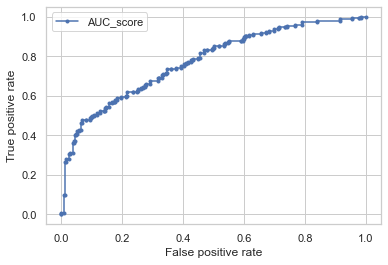

In [23]:
# predict probabilities
# keep probabilities for the positive outcome only
probs = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# calculate AUC
auc = roc_auc_score(y_test, probs)
print('LGBM AUC: {:.4f}'.format(auc))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='AUC_score')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate') 

# show the plot
plt.legend()
plt.show()

LGBM AUC: 0.7749


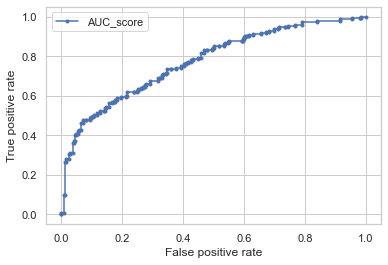

In [40]:
# predict probabilities
# keep probabilities for the positive outcome only
probs = final_model.predict_proba(X_test)[:, 1]

# calculate AUC
auc = roc_auc_score(y_test, probs)
print('LGBM AUC: {:.4f}'.format(auc))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='AUC_score')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate') 

# show the plot
plt.legend()
plt.show()

In [33]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [34]:
from sklearn.metrics import confusion_matrix
y_pred = final_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[170,  75],
       [ 78, 162]], dtype=int64)

Normalized confusion matrix
[[0.69387755 0.30612245]
 [0.325      0.675     ]]


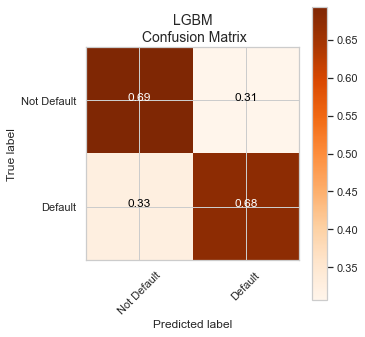

In [41]:
LGBM_conf= confusion_matrix(y_test.values, y_pred)
labels = ['Not Default', 'Default']

fig = plt.figure(figsize=(5,5))
plot_confusion_matrix(LGBM_conf, labels, title="LGBM\n Confusion Matrix", cmap=plt.cm.Oranges, normalize=True)

In [42]:
from sklearn.metrics import classification_report

print('LGBM:')
print(classification_report(y_test.values, y_pred))

LGBM:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       245
           1       0.68      0.68      0.68       240

    accuracy                           0.68       485
   macro avg       0.68      0.68      0.68       485
weighted avg       0.68      0.68      0.68       485



## 11.5 Important features

In [134]:
col_name =  X_train.columns.values
importances = final_model.feature_importances_
print("Important features length {}".format(len(importances)))

imp_df = pd.DataFrame({'Feature':col_name,  'Importance':importances}) 

imp_df.sort_values(by='Importance', ascending=False,inplace=True)

#get featues with no value
no_value = imp_df[imp_df['Importance'] == 0.0]['Feature'].values.tolist()

print("No value feature count {}".format(len(no_value)))
print(("-" * 25) + "\n")

#return features that add value
imp_df[imp_df['Importance'] > 0.0].reset_index(drop=True).head(20)

Important features length 320
No value feature count 58
-------------------------



,Feature,Importance
0,CREDIT_TERM,1238
1,EXT_SOURCE_2,794
2,DAYS_BIRTH,708
3,TIMELY_PERCENT,657
4,EXT_SOURCE_3,655
5,EXT_SOURCE_1,582
6,AMT_ANNUITY,548
7,DAYS_ID_PUBLISH,507
8,POS_BAL_CNT_INSTALMENT_FUTURE_MEAN,493
9,BUREAU_DAYS_CREDIT_ENDDATE_MAX,472


In [63]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [50]:
y_test = y_test.reset_index()

In [109]:
data_subset = X_test.reset_index()

In [110]:
data_subset = data_subset.merge(y_test, how = 'left', on = 'index')

In [111]:
data_subset.drop(['index'],axis=1,inplace=True)

In [92]:
data_subset

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,EXT_SOURCE_2,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,EXT_SOURCE_1,EXT_SOURCE_3,...,NAME_FAMILY_STATUS_MAP_3,NAME_FAMILY_STATUS_MAP_4,NAME_FAMILY_STATUS_MAP_5,NAME_HOUSING_TYPE_MAP_0,NAME_HOUSING_TYPE_MAP_1,NAME_HOUSING_TYPE_MAP_2,NAME_HOUSING_TYPE_MAP_3,NAME_HOUSING_TYPE_MAP_4,NAME_HOUSING_TYPE_MAP_5,TARGET
0,-1.304871,-1.089182,-0.848829,-0.870368,0.631192,0.300325,-0.31024,-0.617391,-0.347620,1.047080,...,0,0,0,0,1,0,0,0,0,1
1,-0.580758,0.164733,-0.577639,1.230599,-0.375141,0.549436,-0.31024,-1.245313,0.186429,-0.148517,...,0,0,0,0,1,0,0,0,0,0
2,1.840900,0.429468,1.929754,-0.135072,-1.343044,0.080936,-0.31024,-1.507785,-1.046940,-0.359903,...,0,0,0,0,1,0,0,0,0,0
3,0.509694,-0.994912,-0.025705,4.009094,2.378153,0.045781,-0.31024,-1.270430,-1.080087,1.135566,...,0,0,1,0,1,0,0,0,0,0
4,-0.178870,0.748108,1.125372,1.230599,0.722890,-0.266533,-0.31024,-0.749255,1.447364,-1.219139,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,-0.291934,-2.017275,-1.173434,0.060848,2.129717,0.362936,-0.31024,0.921018,0.287029,-0.310615,...,0,0,0,0,0,1,0,0,0,0
481,1.525464,0.696804,0.585820,-1.016454,-0.461401,-1.526687,-0.31024,0.004252,-0.246365,0.063192,...,0,0,0,0,1,0,0,0,0,1
482,-0.330949,0.531229,0.235654,0.841759,0.538169,-0.846273,-0.31024,-3.322480,-0.631965,0.218565,...,0,0,0,0,0,1,0,0,0,0
483,0.690262,-1.615262,-1.235613,-0.101785,-0.352461,0.420644,-0.31024,-1.452528,-2.393359,-1.473767,...,0,0,0,0,1,0,0,0,0,1


In [112]:
data_subset.dropna(axis='columns',inplace=True)

In [116]:
def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)


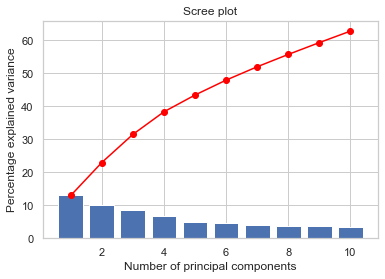

In [117]:
# plot the cumulative sum of 10 PCs into a scree plot to investigate optimal number of components
display_scree_plot(pca) 

In [131]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """Display correlation circles, one for each factorial plane"""

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig, ax = plt.subplots(figsize=(7,7))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see the doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            nr=d1+1
            plt.title("Correlation Circle (PC{} and PC{})".format(d1+1, d2+1))
            plt.show(block=False)
            d = {'values': pca.components_[d1], 'factors': labels}
            df1= pd.DataFrame(d)
            df1.set_index('factors')
            df2=df1.sort_values(by='values', ascending=False)
            df3=df1.sort_values(by='values', ascending=True)
            print("Principal Component" + str(nr)+ " Presenting Values")
            print(df2.head(3))
            print(df3.head(3))
            
            nr=d2+1
            
            d = {'values': pca.components_[d2], 'factors': labels}
            df1= pd.DataFrame(d)
            df1.set_index('factors')
            df2=df1.sort_values(by='values', ascending=False)
            df3=df1.sort_values(by='values', ascending=True)
            print("Principal Component" + str(nr)+ " Presenting Values")
            print(df2.head(3))
            print(df3.head(3))


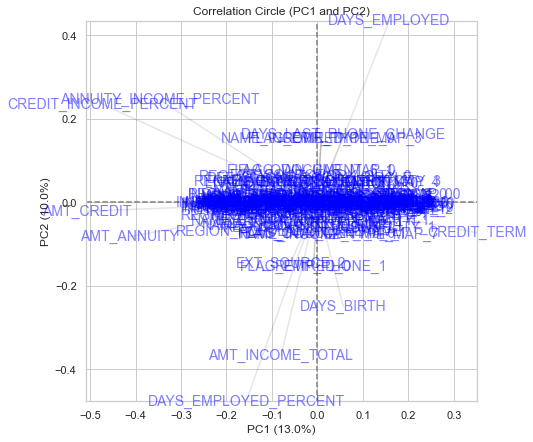

Principal Component1 Presenting Values
    values                 factors
12  0.3509             CREDIT_TERM
15  0.1587           DAYS_EMPLOYED
7   0.0574  DAYS_LAST_PHONE_CHANGE
    values                factors
1  -0.5087             AMT_CREDIT
10 -0.4734  CREDIT_INCOME_PERCENT
2  -0.4127            AMT_ANNUITY
Principal Component2 Presenting Values
    values                 factors
15  0.4344           DAYS_EMPLOYED
11  0.2455  ANNUITY_INCOME_PERCENT
10  0.2349   CREDIT_INCOME_PERCENT
    values                factors
13 -0.4768  DAYS_EMPLOYED_PERCENT
0  -0.3681       AMT_INCOME_TOTAL
14 -0.2502             DAYS_BIRTH


In [132]:
from matplotlib.collections import LineCollection
pca.components_=np.around(pca.components_, decimals=4)
pcs=pca.components_
display_circles(pcs, 10, pca, [(0,1)], labels = np.array(data_subset.columns),)

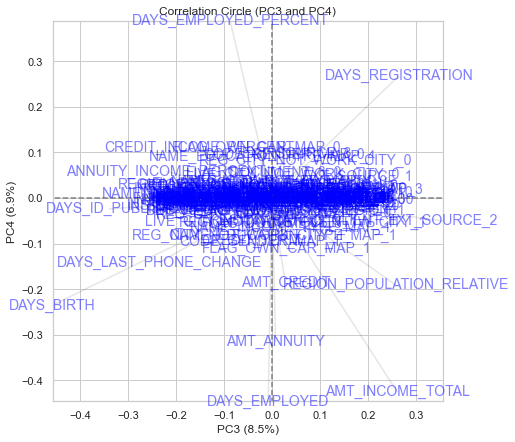

Principal Component3 Presenting Values
   values            factors
5  0.3568       EXT_SOURCE_2
4  0.2645  DAYS_REGISTRATION
0  0.2610   AMT_INCOME_TOTAL
    values                 factors
14 -0.4576              DAYS_BIRTH
16 -0.3405         DAYS_ID_PUBLISH
7  -0.2354  DAYS_LAST_PHONE_CHANGE
Principal Component4 Presenting Values
    values                factors
13  0.3891  DAYS_EMPLOYED_PERCENT
4   0.2683      DAYS_REGISTRATION
78  0.1107     FLAG_OWN_CAR_MAP_0
    values           factors
15 -0.4464     DAYS_EMPLOYED
0  -0.4257  AMT_INCOME_TOTAL
2  -0.3159       AMT_ANNUITY


In [133]:
display_circles(pcs, 10, pca, [(2,3)], labels = np.array(data_subset.columns),)

In [137]:
import shap

In [168]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
bst = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)

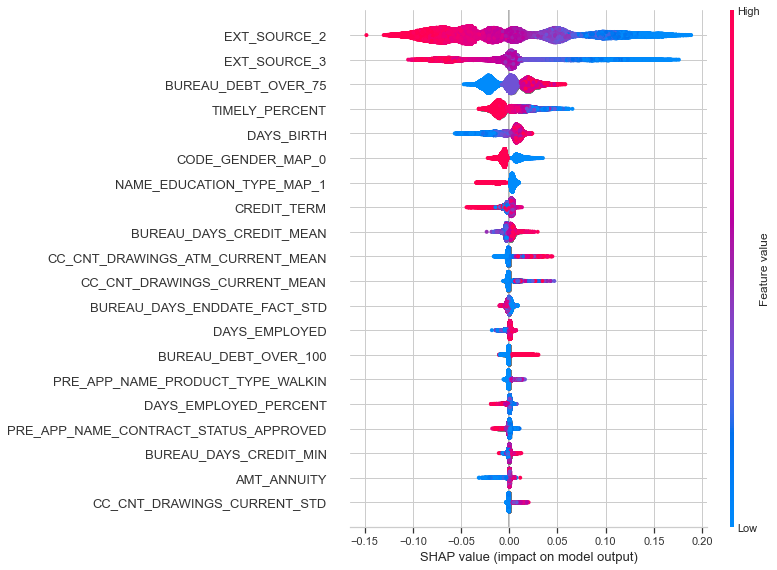

In [175]:
shap.summary_plot(shap_values, X_train)

In [169]:
prediction = bst.predict(xgboost.DMatrix(X_train))

In [174]:
# visualize the first prediction's explaination with default colors
shap.force_plot(explainer.expected_value, shap_values[2,:], X_train.iloc[2,:])

- The output value is the prediction for that observation (the prediction for this observation is 0.47).
- The base value: it is the mean prediction, or mean(yhat) (y_test.mean())
- Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.